# Program to rate characters
Create a model based on a persons appeal to different characters in Genshin Impact
Following this form: https://forms.office.com/Pages/ResponseDetailPage.aspx?id=tTAKZi6OaUe560ryi_0SvUHGZGPvcItElIw3gzwgl7NUMFJZUE5aNDVORVVMRENTSzFQV0laTjc4Vy4u&rid=4&GetResponseToken=q7rahzF2E7Igy2bHzBfrQBctplWW1STeVmCDaCKbsME&origin=rc

#### inputs

In [246]:
import torch as pt
from torch import nn

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

device = "cuda" if pt.cuda.is_available() else "cpu"



#### importing the data

In [247]:
from sys import path

InputData = pd.read_csv(path[0]+'/data/db.csv').drop(columns='Name')
InputData = InputData.to_numpy(dtype=np.double)

TotalOutputData = pd.read_csv(path[0]+'/data/results.csv').drop(columns='Name')

Chosen_person = 'T'
OutputData = TotalOutputData[Chosen_person].to_numpy(dtype=np.double)

print(InputData[0])
print(OutputData[0])

#del TotalOutputData

[0. 3. 5. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 0. 0. 0. 0. 0.]
3.0


In [257]:
# analyse the data
print(f'Mean: {OutputData.mean()}')
print(f'Max: {OutputData.max()}')
print(f'Min: {OutputData.min()}')
print(f'Std: {OutputData.std()}')

vals, counts = np.unique(OutputData, return_counts=True)
mode_value = np.argwhere(counts == np.max(counts))
print(f'Mode: {mode_value.flatten()}') # if there are two values there are equally many of both
del vals, counts, mode_value

Mean: 4.602409638554217
Max: 10.0
Min: 1.0
Std: 2.6749158709263368
Mode: [0 1 2]


#### Splitting the data

In [249]:
from sklearn.model_selection import train_test_split

input_train, input_test, output_train, output_test = train_test_split(InputData, OutputData, test_size=0.2, random_state=41)


print(input_test, "\n"*2, output_test)

[[0. 3. 8. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 3. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 2. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 2. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 3. 7. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 2. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 3. 5. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 3. 5. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.

#### Building a model + loss fn, optimizer

In [250]:
from torch import nn
pt.manual_seed(42)

class ModelV0(nn.Module):
    def __init__(self, input_features:int = 33, output_features:int = 1, hidden_units:int = 30):
        super().__init__()
        self.Layer_1 = nn.Linear(in_features=input_features, out_features=hidden_units)
        #self.Layer_2 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.Layer_3 = nn.Linear(in_features=hidden_units, out_features=output_features)
        self.relu = nn.ReLU()
    def forward(self, x):
        return self.Layer_3(((self.Layer_1(x)))) # self.Layer_2

In [251]:
model0 = ModelV0()

In [252]:
loss_fn = nn.MSELoss() # BCEWithLogitsLoss has tha sigmoid activation function built in
 
optimizer = pt.optim.SGD(params=model0.parameters(), lr=0.01)

In [253]:
# Calculate accuracy, how meny of the the examples the model gets right
def accuracy_fn(y_preds, y_true):
    """tar antalet där y_true == y_preds
    
    Tar detta värdet delat med det hela alltså y_pred * 100 för att få % enheten av gissningar som är rätt"""
    correct = pt.eq(y_true, y_preds).sum().item() # sum tar summan av alla true som även kan ses som 1. item gör sedan om denna summerade siffra från tensor till nummer
    acc = (correct/len(y_preds)) * 100 # delen delat med det hela
    return acc

def standard_devision_func(y_preds, y_true):
    diff = y_preds-y_true
    return pt.std(diff)

#### Train and test loop

In [254]:
#print((input_train.shape))
print(len(input_train[0]))


33


torch.Size([66, 33])
torch.Size([17, 33])
train loss: 25.052383422851562, train acc: 3.0303030303030303,  test loss: 16.941176470588236, test acc: 5.88235294117647, test std: 2.3732578749846107


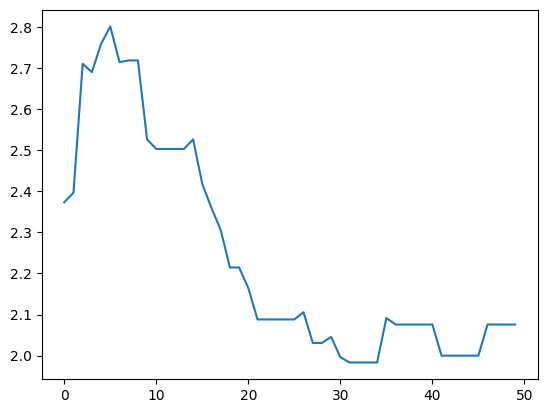

In [255]:
pt.manual_seed(42)
pt.cuda.manual_seed(42)
try:
    input_train, output_train = pt.from_numpy(input_train).to(device), pt.from_numpy(output_train).to(device)
    input_test, output_test = pt.from_numpy(input_test).to(device), pt.from_numpy(output_test).to(device)
except TypeError:
    print('Already tensor')

std_div = []

print(input_train.shape)
# print(input_train.dtype)
# print(output_test.dtype)
print(input_test.shape)

# exit()
for epoch in range(50):

    model0.train()

    y_logits = model0(input_train.to(pt.float32)).squeeze()
    # print(y_logits)
    y_preds = pt.round((y_logits))
    #print(y_logits.dtype, output_train.dtype)
    loss = loss_fn(y_logits, output_train.to(pt.float32))
    train_acc = accuracy_fn(y_preds, output_train)
    
    optimizer.zero_grad()

    loss.backward() # backwards propogation

    optimizer.step() # gradient descend

    model0.eval()
    with pt.inference_mode():
        test_logits = model0(input_test.to(pt.float32)).squeeze()
        test_preds = pt.round((test_logits))
        test_loss = loss_fn(test_preds, output_test)
        test_acc = accuracy_fn(test_preds, output_test)
        test_std = standard_devision_func(test_preds, output_test)
        std_div.append(test_std)
    if epoch % 100 == 0:
        print(f"train loss: {loss}, train acc: {train_acc},  test loss: {test_loss}, test acc: {test_acc}, test std: {test_std}")

plt.plot(std_div)

In [256]:

with pt.inference_mode():
    num = 9
    sample = input_test[num]
    logits = model0(sample.to(pt.float32))
    print((logits))
    print(output_test[num])
    

tensor([5.2152])
tensor(3., dtype=torch.float64)
